MODELO BLACK LITTERMAN

In [153]:
# Load the libraries

import yfinance as yf
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting, objective_functions
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pypfopt import black_litterman 
from pypfopt import BlackLittermanModel 
from sklearn import covariance

In [154]:
# Create a list with 8 Colombia companies and import the data

acciones_colombianas = ["BCOLOMBIA.CL",   
                        "BOGOTA.CL",
                        "CELSIA.CL",
                        "CEMARGOS.CL", 
                        "GRUPOARGOS.CL",  
                        "GRUPOAVAL.CL", 
                        "GRUPOSURA.CL",   
                        "ISA.CL",]

datos = yf.download(acciones_colombianas, start="2008-05-01", end = "2024-05-01", interval = '1mo')['Adj Close']

datos


[*********************100%%**********************]  8 of 8 completed


Ticker,BCOLOMBIA.CL,BOGOTA.CL,CELSIA.CL,CEMARGOS.CL,GRUPOARGOS.CL,GRUPOAVAL.CL,GRUPOSURA.CL,ISA.CL
Date,,,,,,,,
2008-05-01,8531.772461,12163.599609,820.641663,4691.479004,7031.319336,260.986725,14319.093750,5447.839355
2008-06-01,7443.056152,11308.416992,896.254700,4413.695801,6753.769043,226.016037,12178.208008,5303.021484
2008-07-01,7821.683594,11312.124023,899.470276,4505.145020,6632.242188,227.906952,12982.207031,5206.478027
2008-08-01,8191.634277,11866.662109,944.658386,4895.550781,7432.687012,236.790512,13682.684570,5410.366211
2008-09-01,8265.618164,11453.866211,922.109619,4827.384277,7218.281250,242.541672,13293.523438,5354.947266
...,...,...,...,...,...,...,...,...
2023-12-01,31444.076172,26505.107422,2837.073486,6026.782227,12161.183594,455.722382,28411.728516,15057.773438
2024-01-01,31903.199219,30999.501953,3177.330566,6312.832031,13434.092773,496.561554,32184.027344,16860.000000
2024-02-01,32078.492188,31937.673828,3677.252930,6697.520508,13563.343750,465.554779,28678.443359,16720.000000


In [155]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 192 entries, 2008-05-01 to 2024-04-01
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   BCOLOMBIA.CL   192 non-null    float64
 1   BOGOTA.CL      192 non-null    float64
 2   CELSIA.CL      192 non-null    float64
 3   CEMARGOS.CL    192 non-null    float64
 4   GRUPOARGOS.CL  192 non-null    float64
 5   GRUPOAVAL.CL   192 non-null    float64
 6   GRUPOSURA.CL   192 non-null    float64
 7   ISA.CL         192 non-null    float64
dtypes: float64(8)
memory usage: 13.5 KB


In [156]:
import pandas as pd

# Specify the path of the CSV file
archivo_excel = r'C:\Users\Alvaro\OneDrive\Documentos\Optimizacion_R\optimizacion_py\colcap.xltx'

# Load the CSV file into a Pandas DataFrame
market_prices = pd.read_excel(archivo_excel)

market_prices = market_prices[::-1]

# Convert the "Fecha" column to a date data type
market_prices['Fecha'] = pd.to_datetime(market_prices['Fecha'])

market_prices

C:\Users\Alvaro\AppData\Local\Temp\ipykernel_7424\4200353732.py:12: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  market_prices['Fecha'] = pd.to_datetime(market_prices['Fecha'])


,Fecha,Último
3969,2008-01-17,928.38
3968,2008-01-18,903.49
3967,2008-01-21,832.37
3966,2008-01-22,879.67
3965,2008-01-23,890.89
...,...,...
4,2024-04-24,1343.34
3,2024-04-25,1349.93
2,2024-04-26,1366.61
1,2024-04-29,1381.01


In [157]:
precios = market_prices['Último']

In [158]:
# Create a function to get the market capitalizations of each stock

def obtener_capitalizaciones(acciones):
    mcaps = {}
    for accion in acciones:
        try:
            ticker = yf.Ticker(accion)
            info = ticker.info
            mcaps[accion] = info['marketCap']
        except Exception as e:
            print(f"No market capitalization could be obtained for {accion}: {str(e)}")
    return mcaps

mcaps = obtener_capitalizaciones(acciones_colombianas)
mcaps

{'BCOLOMBIA.CL': 34218730061824,
 'BOGOTA.CL': 10053603033088,
 'CELSIA.CL': 4638578835456,
 'CEMARGOS.CL': 9297372119040,
 'GRUPOARGOS.CL': 13100288835584,
 'GRUPOAVAL.CL': 10983463452672,
 'GRUPOSURA.CL': 16578229829632,
 'ISA.CL': 20780077285376}

In [159]:
# Calculate the covariance matrix using a machine learning method that provides more accurate and reliable data

S = risk_models.CovarianceShrinkage(datos, frequency = 12).ledoit_wolf()
S

Ticker,BCOLOMBIA.CL,BOGOTA.CL,CELSIA.CL,CEMARGOS.CL,GRUPOARGOS.CL,GRUPOAVAL.CL,GRUPOSURA.CL,ISA.CL
Ticker,,,,,,,,
BCOLOMBIA.CL,0.075016,0.025020,0.027356,0.039009,0.031598,0.030661,0.040494,0.034927
BOGOTA.CL,0.025020,0.065657,0.023196,0.019520,0.016458,0.026814,0.021985,0.016847
CELSIA.CL,0.027356,0.023196,0.067892,0.029312,0.029841,0.018177,0.021084,0.020787
CEMARGOS.CL,0.039009,0.019520,0.029312,0.124393,0.056196,0.020181,0.032382,0.033339
GRUPOARGOS.CL,0.031598,0.016458,0.029841,0.056196,0.072037,0.020958,0.030925,0.024241
GRUPOAVAL.CL,0.030661,0.026814,0.018177,0.020181,0.020958,0.057016,0.023860,0.020584
GRUPOSURA.CL,0.040494,0.021985,0.021084,0.032382,0.030925,0.023860,0.070571,0.026182
ISA.CL,0.034927,0.016847,0.020787,0.033339,0.024241,0.020584,0.026182,0.058302


In [160]:
# Calculate the market's risk aversion

delta = black_litterman.market_implied_risk_aversion(precios)


In [161]:
delta

0.622640707552318

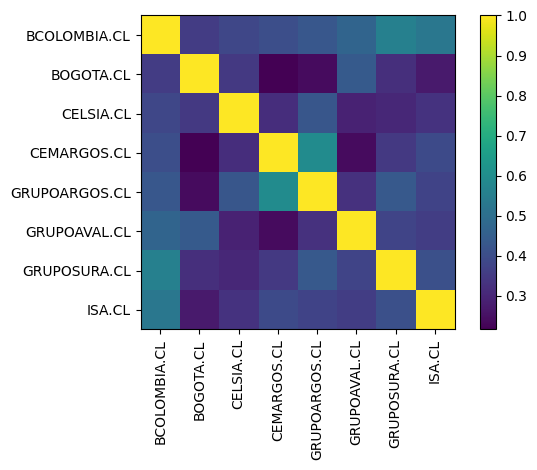

In [162]:
# Plot the correlation of the assets

plotting.plot_covariance(S, plot_correlation=True);

In [163]:
# Calculate the initial returns before introducing the views

prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)

In [164]:
prior

Ticker
BCOLOMBIA.CL     0.048391
BOGOTA.CL        0.035768
CELSIA.CL        0.036282
CEMARGOS.CL      0.046077
GRUPOARGOS.CL    0.041325
GRUPOAVAL.CL     0.037250
GRUPOSURA.CL     0.042828
ISA.CL           0.040608
dtype: float64

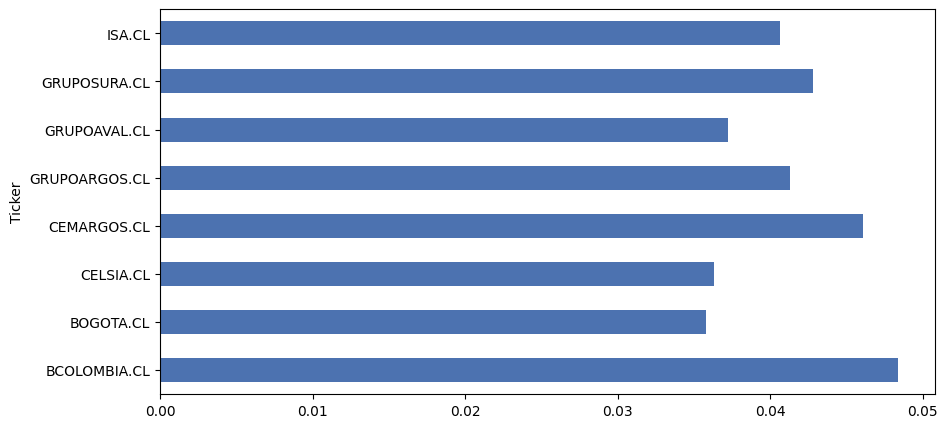

In [165]:
# Plot the expected returns by the Black-Litterman model

prior.plot.barh(figsize=(10,5));f 

In [166]:
# Introduce the investor's views

viewdict = {"BCOLOMBIA.CL":0.10,   
            "BOGOTA.CL":-0.02,
            "CELSIA.CL":0.09,
            "CEMARGOS.CL":-0.01, 
            "GRUPOARGOS.CL":-0.02,  
            "GRUPOAVAL.CL":0.08, 
            "GRUPOSURA.CL":0.17,   
            "ISA.CL":0.12}

                        


In [167]:
# Introduce the confidence level of the views

confidences = [
    0.6,
    0.4,
    0.2,
    0.3,
    0.4, 
    0.5,
    0.8,
    0.4
]

In [168]:
# Calculate the final (posterior) returns without considering priors

bl = BlackLittermanModel(S, absolute_views=viewdict)
ret_bl = bl.bl_returns()
ret_bl

c:\Users\Alvaro\AppData\Local\Programs\Python\Python311\Lib\site-packages\pypfopt\black_litterman.py:259: UserWarning: Running Black-Litterman with no prior.
  warnings.warn("Running Black-Litterman with no prior.")


Ticker
BCOLOMBIA.CL     0.079103
BOGOTA.CL        0.017239
CELSIA.CL        0.053776
CEMARGOS.CL      0.022047
GRUPOARGOS.CL    0.021841
GRUPOAVAL.CL     0.054129
GRUPOSURA.CL     0.092779
ISA.CL           0.073293
dtype: float64

In [169]:
# Calculate the final (posterior) returns

bl = BlackLittermanModel(S, pi=prior, absolute_views=viewdict)
ret_bl = bl.bl_returns()
ret_bl

Ticker
BCOLOMBIA.CL     0.089128
BOGOTA.CL        0.025661
CELSIA.CL        0.061410
CEMARGOS.CL      0.029802
GRUPOARGOS.CL    0.030211
GRUPOAVAL.CL     0.062788
GRUPOSURA.CL     0.102029
ISA.CL           0.083287
dtype: float64

In [170]:
# Calculate the final (posterior) returns calculated by the "idzorek" model

bl = BlackLittermanModel(S, pi=prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)
ret_bl = bl.bl_returns()
ret_bl

Ticker
BCOLOMBIA.CL     0.099252
BOGOTA.CL        0.036446
CELSIA.CL        0.055121
CEMARGOS.CL      0.050588
GRUPOARGOS.CL    0.046107
GRUPOAVAL.CL     0.067830
GRUPOSURA.CL     0.140740
ISA.CL           0.084102
dtype: float64

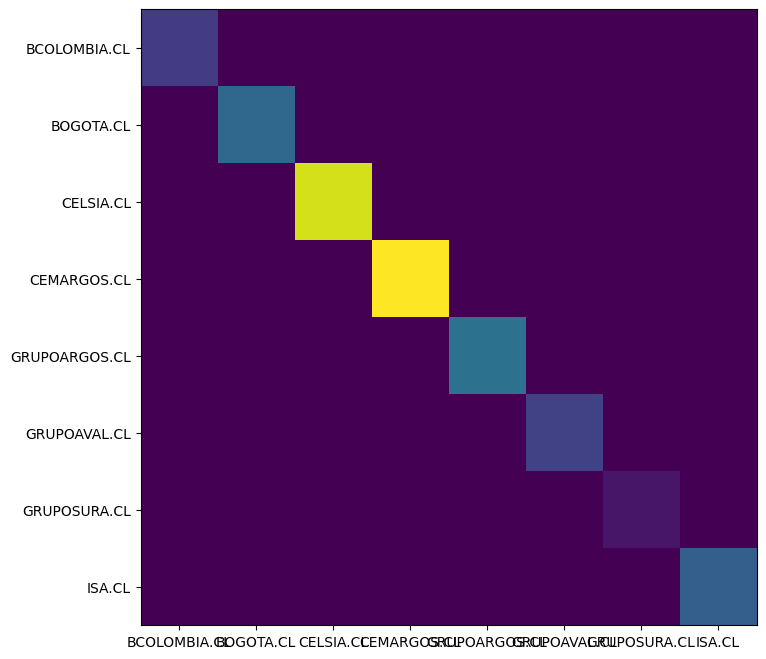

In [171]:
# Observe the automatically calculated uncertainty level by the model

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(bl.omega)

ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [172]:
# Observe the numerical uncertainty level

np.diag(bl.omega)

array([0.00250052, 0.00492426, 0.01357841, 0.01451253, 0.00540275,
       0.0028508 , 0.00088214, 0.00437262])

In [173]:
# Create expected return intervals in order to create a more reliable and investor-adjusted uncertainty level

intervals = [
    (0.05, 0.15),
    (-0.1, 0.1),
    (0.06, 0.12),
    (-0.02, 0.06),
    (-0.03, 0.1),
    (-0.1, 0.2),
    (0.12, 0.2),
    (0.08, 0.2)
]

In [174]:
# Add the variances to the omega vector

variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)


omega = np.diag(variances)
variances

[0.0024999999999999996,
 0.010000000000000002,
 0.0009,
 0.0016,
 0.0042250000000000005,
 0.022500000000000006,
 0.0016000000000000007,
 0.0036000000000000008]

In [175]:
# Calculate the final expected posterior return

bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [176]:
# Posterior estimation

ret_bl = bl.bl_returns()
ret_bl

Ticker
BCOLOMBIA.CL     0.093185
BOGOTA.CL        0.040374
CELSIA.CL        0.075865
CEMARGOS.CL      0.009395
GRUPOARGOS.CL    0.029484
GRUPOAVAL.CL     0.054126
GRUPOSURA.CL     0.122427
ISA.CL           0.077072
dtype: float64

In [177]:
# Compare the expected data output by the model against those of
# the investor and the combination of both with the Bayesian method to calculate the final posterior return

rets_df = pd.DataFrame([prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
BCOLOMBIA.CL,0.048391,0.093185,0.10
BOGOTA.CL,0.035768,0.040374,-0.02
CELSIA.CL,0.036282,0.075865,0.09
CEMARGOS.CL,0.046077,0.009395,-0.01
GRUPOARGOS.CL,0.041325,0.029484,-0.02
GRUPOAVAL.CL,0.037250,0.054126,0.08
GRUPOSURA.CL,0.042828,0.122427,0.17
ISA.CL,0.040608,0.077072,0.12


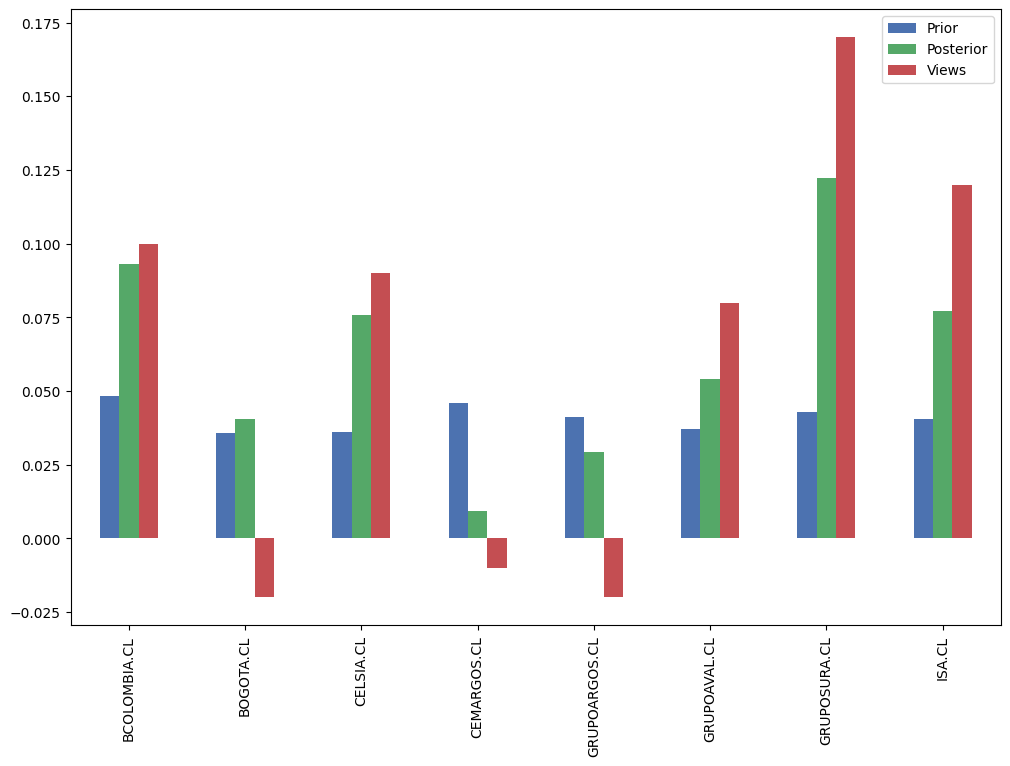

In [178]:
# Plot the comparison

rets_df.plot.bar(figsize=(12,8));

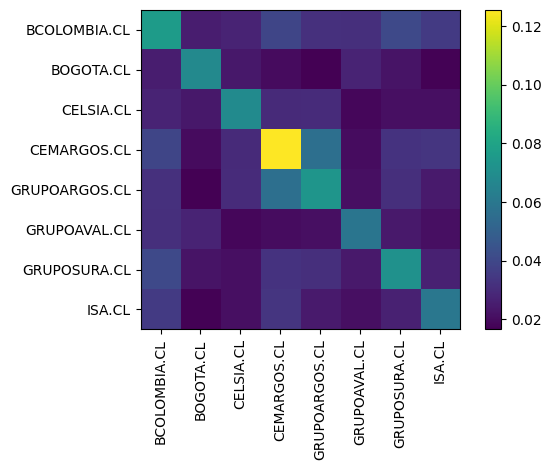

In [179]:
# Plot the manually created uncertainty level

S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

In [187]:
# Calculate the efficient frontier using a machine learning process to avoid concentration of weights in assets

ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
rendimiento_esperado, volatilidad, razon_sharpe = ef.portfolio_performance(verbose=True)
weights

Expected annual return: 9.1%
Annual volatility: 19.1%
Sharpe Ratio: 0.37


OrderedDict([('BCOLOMBIA.CL', 0.21154),
             ('BOGOTA.CL', 0.04631),
             ('CELSIA.CL', 0.16456),
             ('CEMARGOS.CL', 0.0),
             ('GRUPOARGOS.CL', 0.00454),
             ('GRUPOAVAL.CL', 0.09155),
             ('GRUPOSURA.CL', 0.31454),
             ('ISA.CL', 0.16696)])

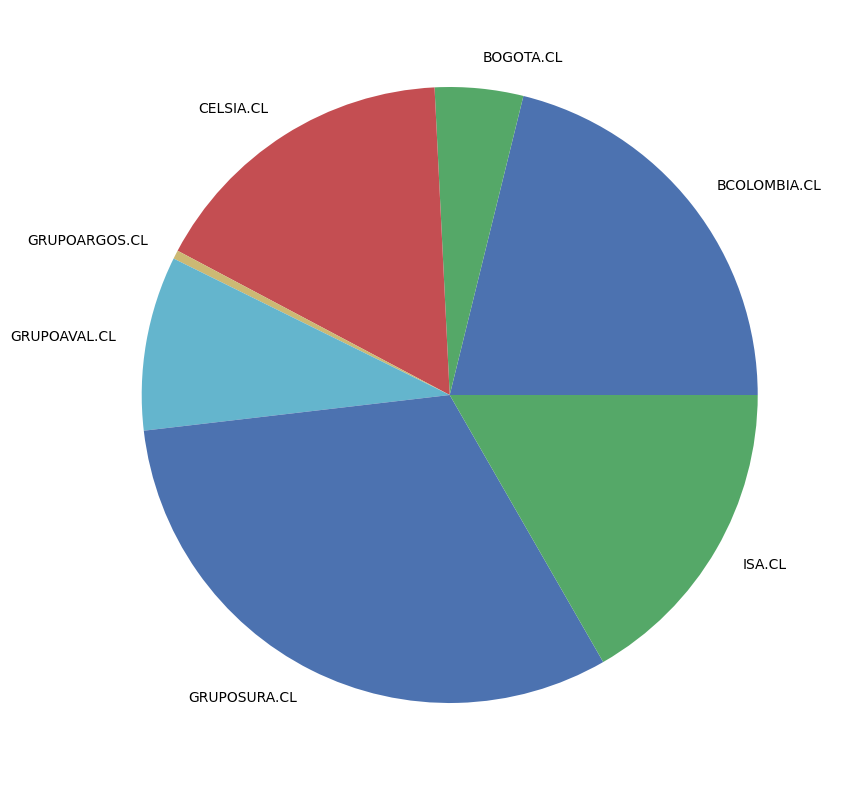

In [181]:
# Through a pie chart, observe the weights for each asset of the optimal portfolio

pd.Series(weights).plot.pie(figsize=(10,10));

In [188]:
# Calculate the efficient frontier for the graph

ef = EfficientFrontier(ret_bl, S_bl)
ef.max_sharpe()
rendimiento_esperado, volatilidad, razon_sharpe = ef.portfolio_performance(verbose=True)

Expected annual return: 10.6%
Annual volatility: 21.5%
Sharpe Ratio: 0.40


c:\Users\Alvaro\AppData\Local\Programs\Python\Python311\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
C:\Users\Alvaro\AppData\Local\Temp\ipykernel_7424\439550249.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


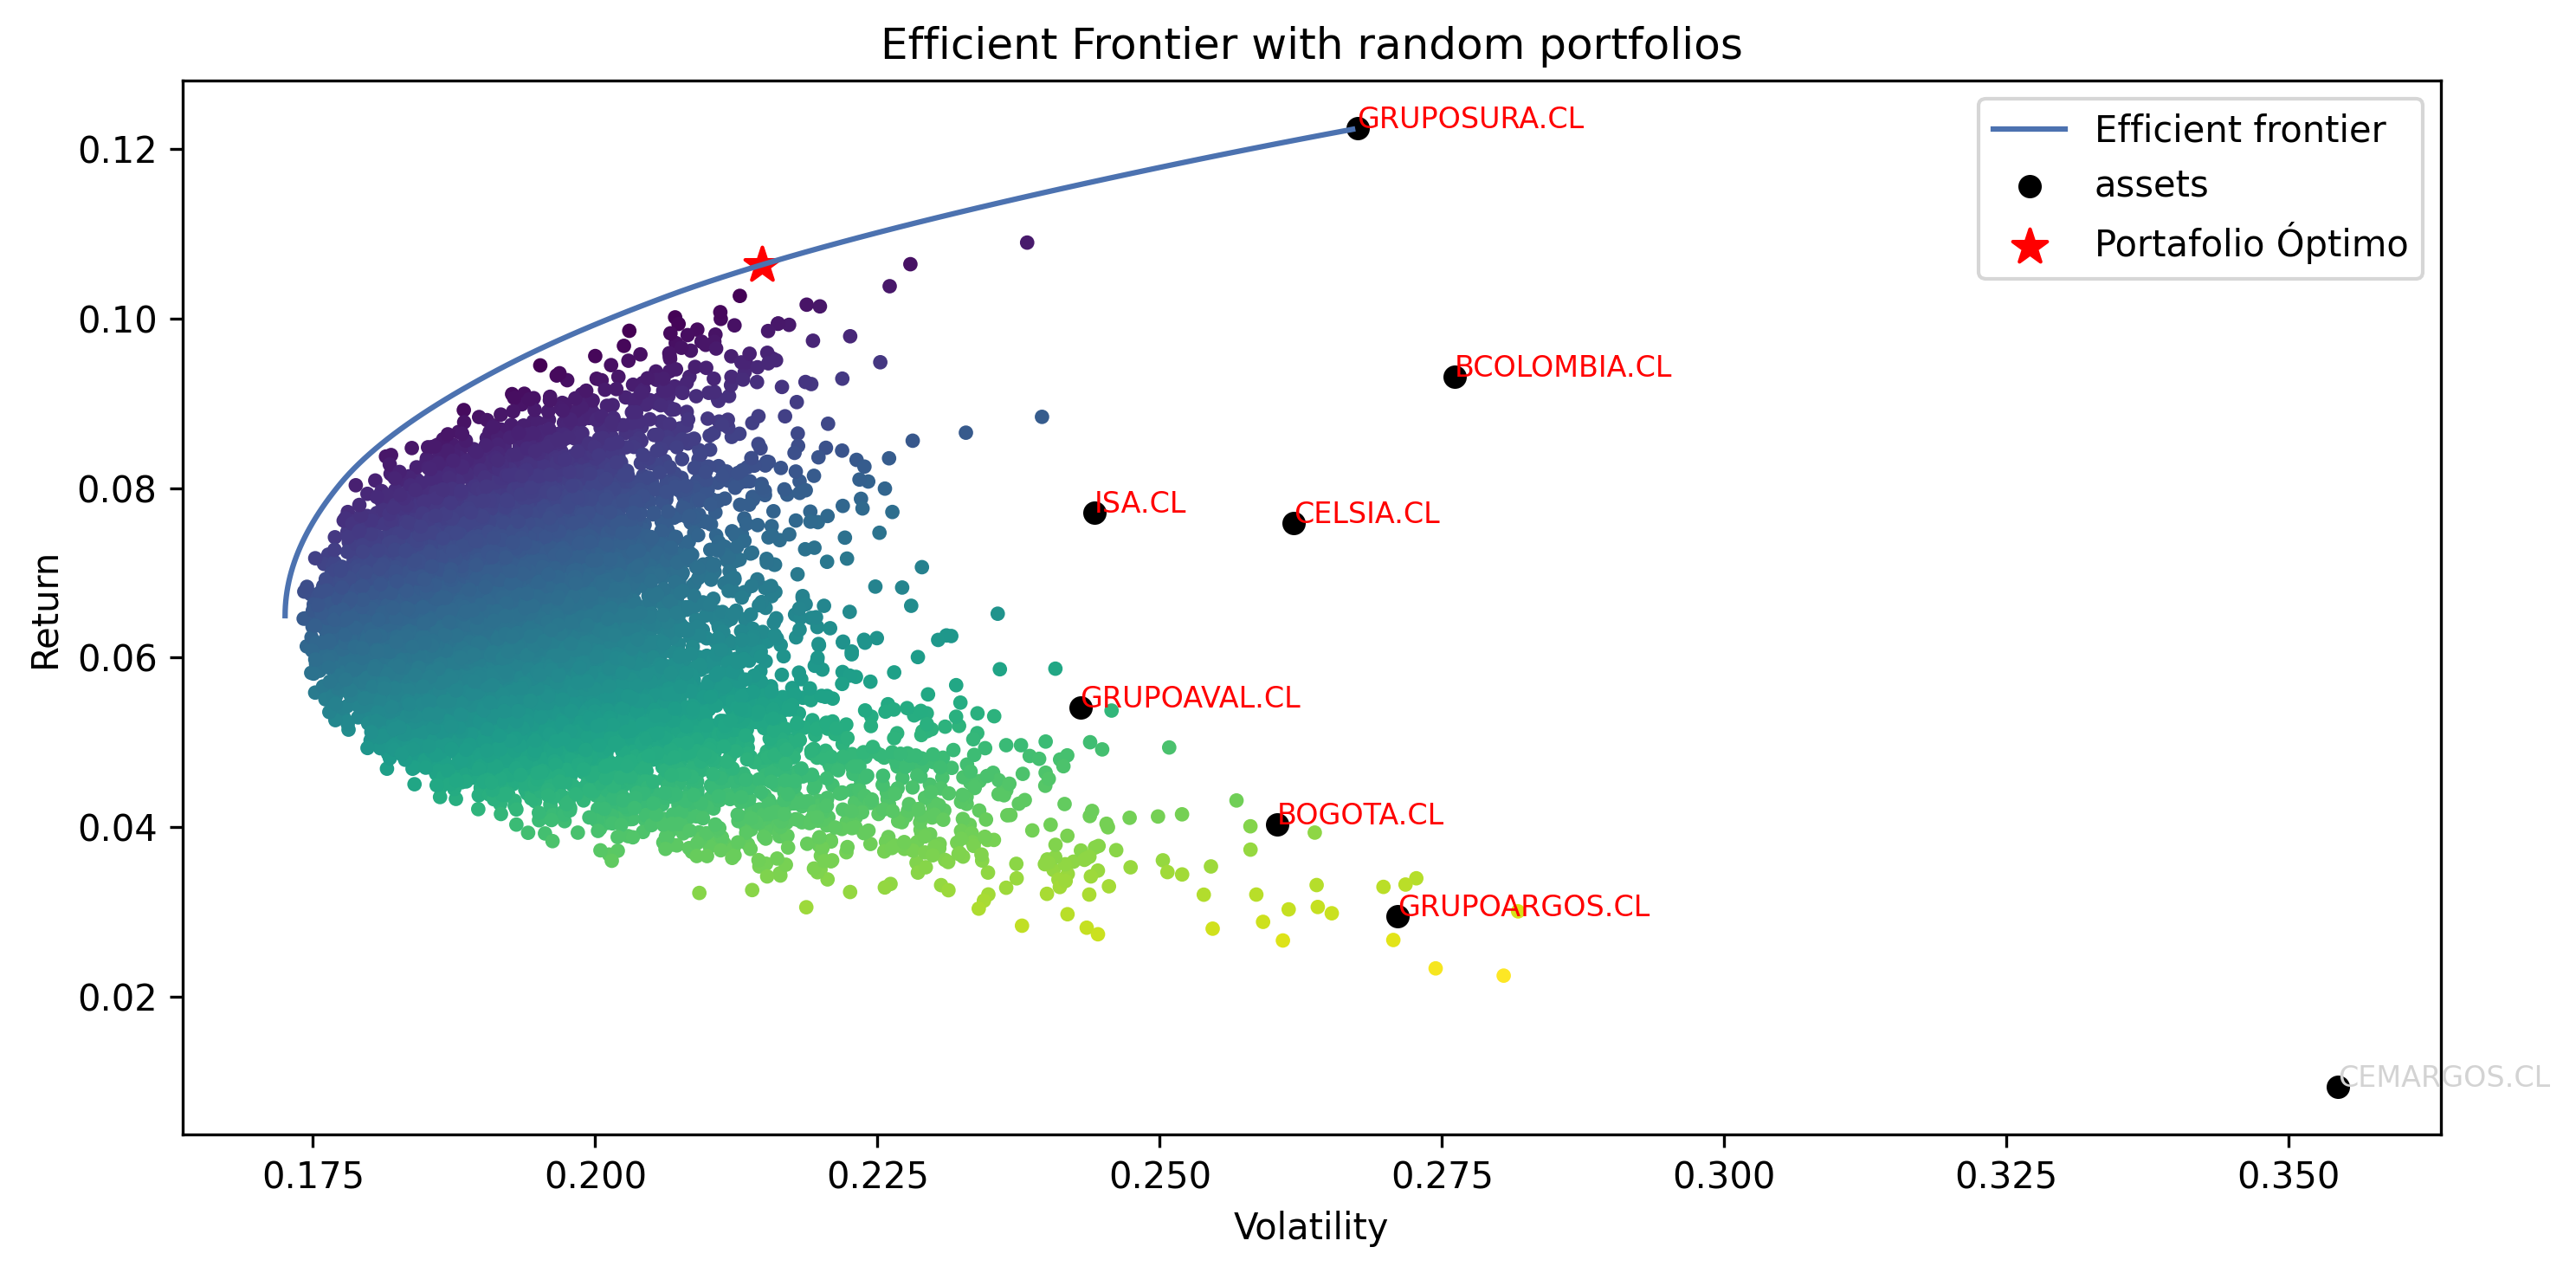

In [189]:
ef = EfficientFrontier(ret_bl, S_bl)

# Plot the efficient frontier
fig, ejes = plt.subplots(figsize=(10, 5), dpi=300)
plotting.plot_efficient_frontier(ef, ax=ejes, show_assets=True)

# Mark the optimal portfolio
ejes.scatter(volatilidad, rendimiento_esperado, marker='*', color='red', s=100, label='Portafolio Óptimo')

for activo, peso in weights.items():
    # Calculate the volatility and expected return of the asset
    volatilidad_activo = S_bl.loc[activo, activo] ** 0.5
    retorno_esperado_activo = ret_bl[activo]

    # Mark the asset on the graph
    ejes.annotate(activo, 
                  (volatilidad_activo, retorno_esperado_activo), 
                  color='red' if peso > 0 else 'lightgray', 
                  fontsize=8)  # Change to light gray color and reduce font size

# Change to light gray color and reduce font size
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ejes.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ejes.set_title("Efficient Frontier with random portfolios")
ejes.legend()
plt.tight_layout()
plt.show()

In [184]:
S_bl

Ticker,BCOLOMBIA.CL,BOGOTA.CL,CELSIA.CL,CEMARGOS.CL,GRUPOARGOS.CL,GRUPOAVAL.CL,GRUPOSURA.CL,ISA.CL
Ticker,,,,,,,,
BCOLOMBIA.CL,0.076235,0.025205,0.027424,0.039098,0.031712,0.030989,0.040709,0.035194
BOGOTA.CL,0.025205,0.067795,0.023326,0.019556,0.016487,0.027386,0.022124,0.016956
CELSIA.CL,0.027424,0.023326,0.068570,0.029345,0.029952,0.018247,0.021113,0.020845
CEMARGOS.CL,0.039098,0.019556,0.029345,0.125580,0.056479,0.020206,0.032431,0.033452
GRUPOARGOS.CL,0.031712,0.016487,0.029952,0.056479,0.073477,0.021128,0.031070,0.024334
GRUPOAVAL.CL,0.030989,0.027386,0.018247,0.020206,0.021128,0.059027,0.024020,0.020790
GRUPOSURA.CL,0.040709,0.022124,0.021113,0.032431,0.031070,0.024020,0.071554,0.026298
ISA.CL,0.035194,0.016956,0.020845,0.033452,0.024334,0.020790,0.026298,0.059630
